<center>
<img src="../../img/ods_stickers.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Author: [Yury Kashnitsky](https://www.linkedin.com/in/festline/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

## <center> Assignment 4 (demo)
### <center>  Sarcasm detection with logistic regression
    
**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit) + [solution](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution).**


We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [32]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install plotly

     |████████████████████████████████| 7.1MB 2.1MB/s eta 0:00:01


In [38]:
import plotly.graph_objects as go
import plotly.offline as py
from plotly import tools

In [5]:
!ls ../input/sarcasm/

test-balanced.csv          train-balanced-sarc.csv.gz
test-unbalanced.csv        train-balanced-sarcasm.csv


In [6]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [7]:
train_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [8]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [10]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [11]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [20]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

In [23]:
y_train.values

array([0, 1, 0, ..., 0, 0, 1])

# Task 1  - Analyzing the dataset

In [50]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


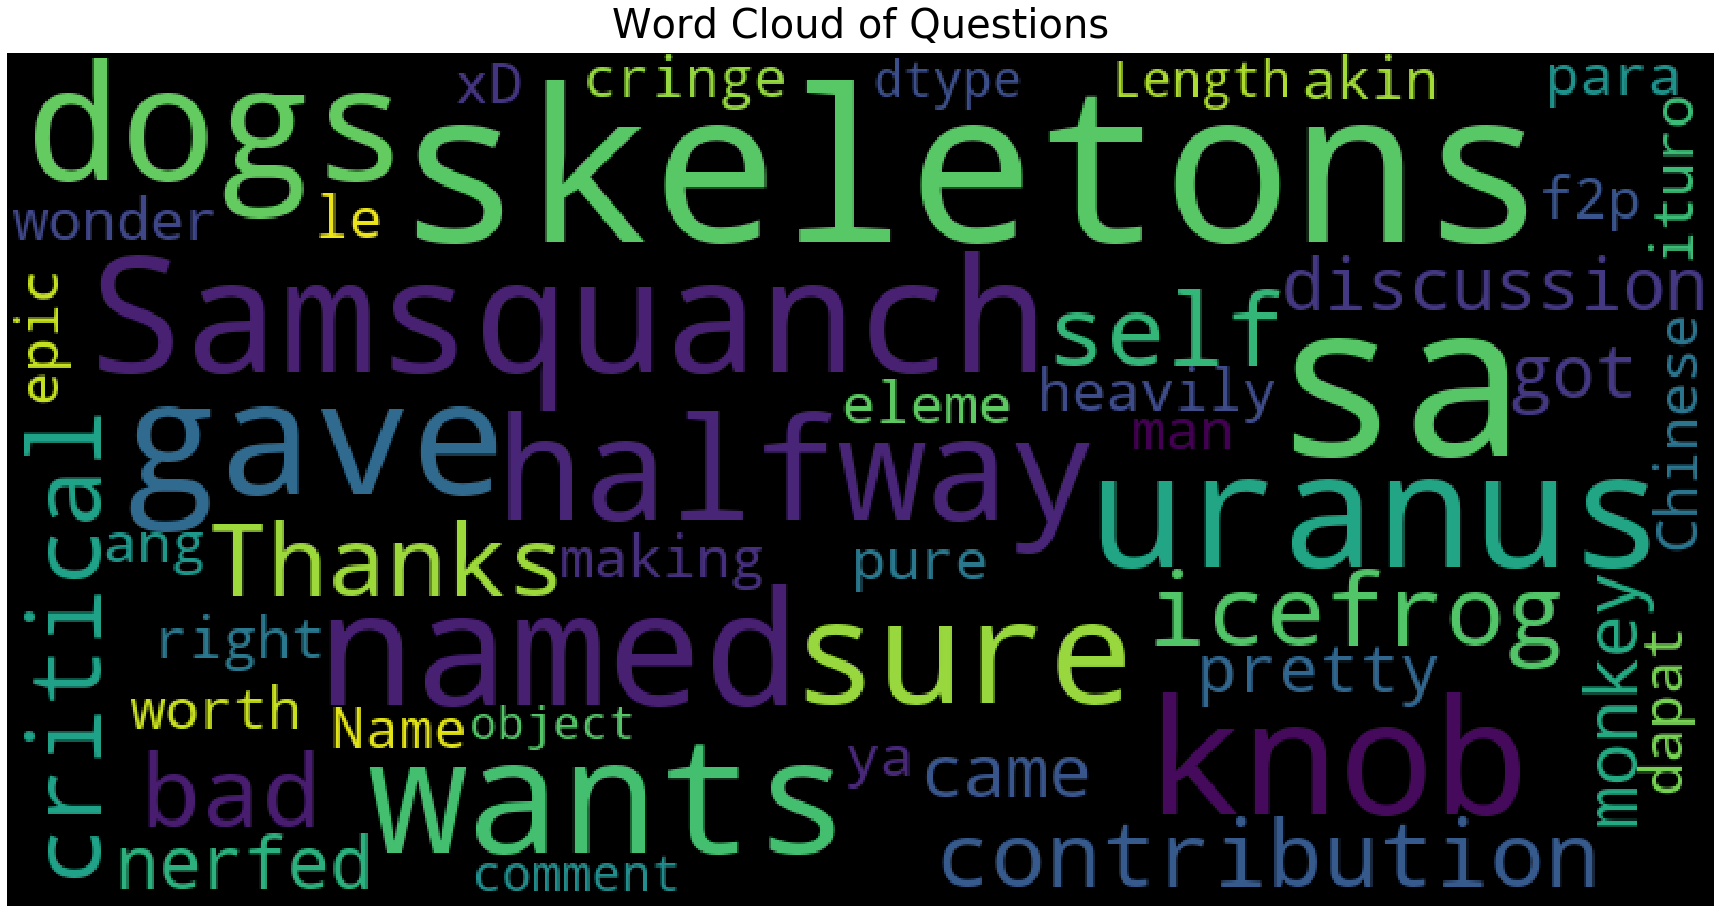

In [17]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_texts, title="Word Cloud of Questions")

In [40]:
from collections import defaultdict
train1_df = train_df[train_df['label']==1]
train0_df = train_df[train_df['label']==0]


## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non-sarcastic comments", 
                                          "Frequent words of sarcastic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

# Task 2

In [52]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [66]:
%%time
classifier = tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 31.9 s, sys: 1.26 s, total: 33.2 s
Wall time: 47.1 s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.4s finished


In [67]:
predicted = classifier.predict(valid_texts)

In [68]:
print("The accuracy is " + str(accuracy_score(y_valid, predicted)))

The accuracy is 0.7208560551497067


# Task 3

In [81]:
from eli5 import explain_weights, explain_prediction, show_weights

In [86]:
explain_weights(classifier)

Weight?,Feature
+9.684,yes because
+8.014,clearly
+7.545,obviously
+7.480,yeah because
+7.005,totally
+6.503,because
+6.111,how dare
+6.033,right because
+5.596,but thought
+5.282,duh


## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions